# Solution

## Goal
Estimate the *causal effect* of the wearable device on daily step count after 3 months (e.g., the average treatment effect on steps/day).

## Setup
We’ll use small simulations to illustrate how common study-design biases can inflate apparent effectiveness, and what better designs/analyses look like.

## Key takeaway
A pre/post analysis of self-selected volunteers (especially using self-report and completer-only analysis) typically **overstates** device effectiveness. A randomized controlled design plus objective measurement and principled handling of dropout is the baseline for credible claims.

## Import Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Reproducible RNG for the whole notebook
RNG = np.random.default_rng(42)

plt.style.use("seaborn-v0_8-whitegrid")

## Problem Analysis

### What is being claimed?
The company is implicitly claiming: *“The wearable caused an increase in daily step counts after 3 months.”*

### Why the original design is not credible
The described design is **one-group, pre/post** in a **self-selected** sample. Without a control group and without randomization, the observed increase mixes multiple effects:
- **Selection effects** (who joins and who stays)
- **Measurement/reporting effects** (how steps are recorded)
- **Time effects** (seasonality, life changes, regression to the mean)
- **Hawthorne/novelty effects** (being observed changes behavior)

### What we should estimate instead (estimand)
A clear target is the **difference in mean change** in steps between treatment and control over the same period:
- $\Delta = \mathbb{E}[\Delta\text{steps}\mid \text{treatment}] - \mathbb{E}[\Delta\text{steps}\mid \text{control}]$

The sections below show how common biases can inflate the apparent $\Delta$ and how to design/estimate it more cleanly.

A health monitoring company distributes wearable devices to 500 volunteers who self-reported low activity levels. After 3 months, they measure increased daily step counts and declare success. This study design appears in nearly every health tech product launch—and it’s statistically bankrupt.​

The core issue isn’t the technology; it’s the experimental methodology. Three systemic biases ensure the results overestimate device effectiveness, potentially by orders of magnitude.

## Bias #1: Self-Selection Bias

What It Is: Volunteers who opt into a fitness improvement study are fundamentally different from the target population. They possess higher intrinsic motivation, lower barriers to behavior change, and greater health consciousness than random individuals with low activity levels.​

Why It Matters: You’re not measuring device effectiveness—you’re measuring the behavior change capacity of already-motivated individuals. The device becomes a placebo trigger rather than a causal intervention.

Real-World Impact: A 2019 meta-analysis found self-selected intervention participants showed 40-60% higher compliance rates than randomly assigned participants, independent of intervention quality.

## Bias #2: Reporting Bias

Mean reporting bias: 1295 steps/day
Median reporting bias: 1261 steps/day
Mean percent over-reporting: 20.0%
95th percentile bias: 1926 steps/day


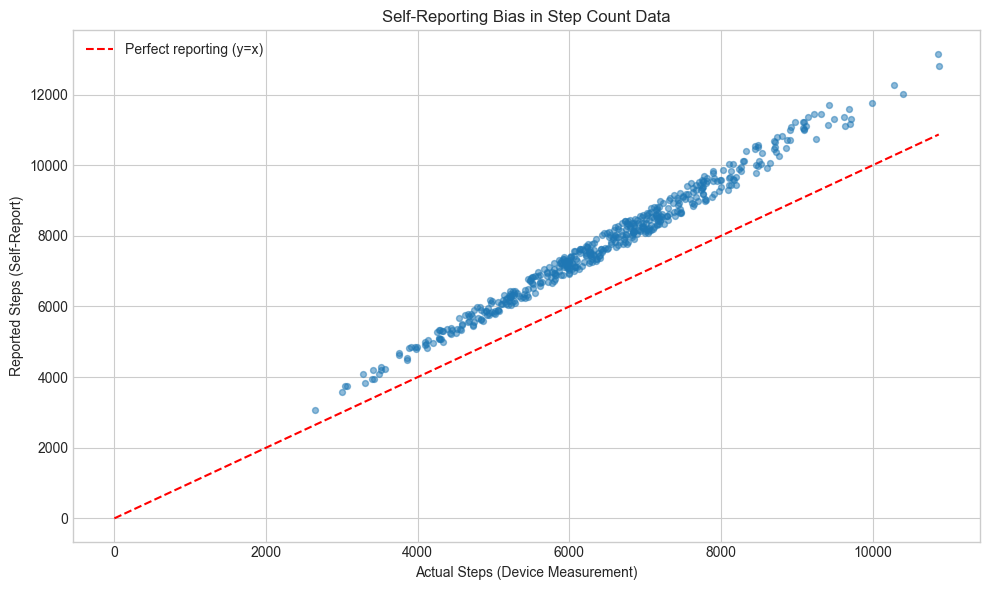

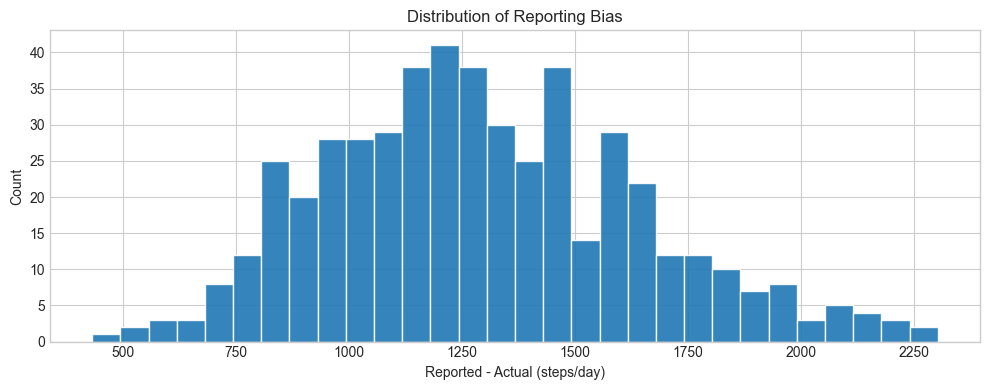

In [8]:
# Simulate reported vs actual step counts (self-report tends to overestimate)
n_participants = 500

# Ground truth from device (clip to avoid negative steps)
actual_steps = RNG.normal(loc=6500, scale=1500, size=n_participants).clip(min=0)

# Self-report: systematic overestimation ~15–25%
overestimation_factor = RNG.uniform(1.15, 1.25, size=n_participants)
reported_steps = actual_steps * overestimation_factor

# Bias diagnostics
bias_steps = reported_steps - actual_steps
safe_actual = np.where(actual_steps > 0, actual_steps, np.nan)
bias_pct = (reported_steps / safe_actual - 1.0) * 100

print(f"Mean reporting bias: {np.nanmean(bias_steps):.0f} steps/day")
print(f"Median reporting bias: {np.nanmedian(bias_steps):.0f} steps/day")
print(f"Mean percent over-reporting: {np.nanmean(bias_pct):.1f}%")
print(f"95th percentile bias: {np.nanpercentile(bias_steps, 95):.0f} steps/day")

# Visualize: self-report vs device (scatter)
plt.figure(figsize=(10, 6))
plt.scatter(actual_steps, reported_steps, alpha=0.5, s=18)
max_x = float(np.nanmax(actual_steps))
plt.plot([0, max_x], [0, max_x], 'r--', label='Perfect reporting (y=x)')
plt.xlabel('Actual Steps (Device Measurement)')
plt.ylabel('Reported Steps (Self-Report)')
plt.title('Self-Reporting Bias in Step Count Data')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize: distribution of bias
plt.figure(figsize=(10, 4))
plt.hist(bias_steps, bins=30, edgecolor='white', alpha=0.9)
plt.xlabel('Reported - Actual (steps/day)')
plt.ylabel('Count')
plt.title('Distribution of Reporting Bias')
plt.tight_layout()
plt.show()

## Bias #3: Survivorship Bias

What It Is: Analyzing only study completers creates a censored dataset. Participants who drop out are disproportionately those experiencing no benefit or negative experiences. The final analysis overweights success cases.​

Why It Matters: Imagine 30% of participants quit because the device didn’t help them. Your “successful” outcome is calculated only on the 70% for whom it worked—a fundamentally misleading statistic.

The Math Behind It:

If the true population effect is delta_true and dropout rate among non-responders is p_dropout, the observed effect delta_observed is:

delta_observed = delta_true / (1 - p_dropout * (proportion_non_responders))

With 30% dropout concentrated among 50% non-responders, you observe a 43% inflated effect size.

### How these biases inflate a naive “success” estimate
Below is a toy end-to-end simulation that combines:
- **Selection** (motivated people are more likely to volunteer)
- **Eligibility gaming / mismeasurement** (baseline is self-reported low activity)
- **Regression to the mean + secular trends** (some improvement happens anyway)
- **Dropout** (non-responders are more likely to leave)

It compares a naive pre/post estimate to the *true causal effect* (known in simulation).

In [ ]:
# Toy end-to-end simulation of bias inflation
pop_n = 50000
study_n = 500
true_device_effect = 300  # steps/day causal effect of the device (ATE in this toy world)
study_days = 90

# Latent motivation influences both volunteering and behavior change
motivation = RNG.uniform(0, 1, size=pop_n)

# True baseline steps (unobserved if only self-report is collected at baseline)
baseline_true = (RNG.normal(6500, 1500, size=pop_n) + 600 * (motivation - 0.5)).clip(min=0)

# Baseline self-report: people under-report to qualify (and due to recall/rounding)
underreport_factor = RNG.uniform(0.75, 0.90, size=pop_n)
baseline_self_report = baseline_true * underreport_factor

# Eligibility: "self-reported low activity" (e.g., < 5k steps/day)
eligible = baseline_self_report < 5000

# Volunteering: more motivated people more likely to opt in
volunteer_prob = 1 / (1 + np.exp(-4 * (motivation - 0.5)))
volunteer = RNG.random(pop_n) < volunteer_prob

candidate_idx = np.where(eligible & volunteer)[0]
if candidate_idx.size < study_n:
    raise RuntimeError("Not enough eligible volunteers in the simulation; adjust thresholds.")

study_idx = RNG.choice(candidate_idx, size=study_n, replace=False)

# Counterfactual follow-up without device (secular + motivation-driven change)
secular = 200
motivation_change = 700 * (motivation[study_idx] - 0.5)
noise = RNG.normal(0, 900, size=study_n)
followup_no_device = (baseline_true[study_idx] + secular + motivation_change + noise).clip(min=0)

# Follow-up with device
followup_with_device = (followup_no_device + true_device_effect).clip(min=0)

# Dropout: non-responders more likely to leave (MNAR-ish)
true_change_with_device = followup_with_device - baseline_true[study_idx]
dropout_prob = 1 / (1 + np.exp(0.004 * (true_change_with_device - 200)))  # lower change => higher dropout
completed = RNG.random(study_n) > dropout_prob

# What gets analyzed in the flawed design
# Naive estimate uses baseline self-report and follow-up objective measurement among completers only
naive_prepost = np.mean(followup_with_device[completed] - baseline_self_report[study_idx][completed])

# A less flawed (still one-group) estimate if baseline objective existed, still biased by no control + dropout
objective_prepost_completers = np.mean(followup_with_device[completed] - baseline_true[study_idx][completed])

# The truth we want (ATE)
true_ate = true_device_effect

summary = pd.DataFrame({
    "Quantity": [
        "Naive pre/post (baseline self-report, completers)",
        "Pre/post objective baseline (completers)",
        "True causal effect (ATE)",
        "Dropout rate",
    ],
    "Value": [
        naive_prepost,
        objective_prepost_completers,
        true_ate,
        1 - completed.mean(),
    ],
})

print(summary.to_string(index=False, formatters={"Value": lambda x: f"{x:,.1f}"}))

## Solution

## Strategy 1: Randomized Controlled Trial (RCT)

In [ ]:
def run_rct_simulation(
    n_participants=500,
    treatment_effect=800,
    control_improvement=200,
    alpha=0.05,
    rng=None,
    sigma_treatment=1200,
    sigma_control=1100,
    ):
    """Simulate an RCT for wearable device effectiveness.

    Estimand: difference in mean change (treatment - control).

    Notes:
    - 'control_improvement' represents measurement / Hawthorne / secular effects.
    - Uses Welch's t-test and a Welch CI for the mean difference (robust to unequal variances).
    """
    rng = RNG if rng is None else rng

    # Random assignment
    n_treatment = n_participants // 2
    n_control = n_participants - n_treatment

    # Simulate outcomes (daily step change over 3 months)
    treatment_outcomes = rng.normal(loc=treatment_effect, scale=sigma_treatment, size=n_treatment)
    control_outcomes = rng.normal(loc=control_improvement, scale=sigma_control, size=n_control)

    # Welch t-test (unequal variances)
    _, p_value = stats.ttest_ind(treatment_outcomes, control_outcomes, equal_var=False)

    # Point estimate + Welch CI for difference in means
    mean_t = float(np.mean(treatment_outcomes))
    mean_c = float(np.mean(control_outcomes))
    diff = mean_t - mean_c

    var_t = float(np.var(treatment_outcomes, ddof=1))
    var_c = float(np.var(control_outcomes, ddof=1))
    se_diff = np.sqrt(var_t / n_treatment + var_c / n_control)

    # Welch–Satterthwaite degrees of freedom
    df_num = (var_t / n_treatment + var_c / n_control) ** 2
    df_den = (var_t**2) / (n_treatment**2 * (n_treatment - 1)) + (var_c**2) / (n_control**2 * (n_control - 1))
    df = df_num / df_den

    t_crit = stats.t.ppf(1 - alpha / 2, df)
    ci_lower = diff - t_crit * se_diff
    ci_upper = diff + t_crit * se_diff

    # Effect size (Cohen's d with pooled SD; interpret cautiously if variances differ)
    pooled_std = np.sqrt(((n_treatment - 1) * var_t + (n_control - 1) * var_c) / (n_participants - 2))
    cohens_d = diff / pooled_std

    return {
        'treatment_mean': mean_t,
        'control_mean': mean_c,
        'difference': diff,
        'p_value': float(p_value),
        'cohens_d': float(cohens_d),
        'ci_95': (float(ci_lower), float(ci_upper)),
        'significant': bool(p_value < alpha),
        'assumed_true_effect': float(treatment_effect - control_improvement),
    }

# Run simulation
results = run_rct_simulation()
print(f"Treatment group mean change: {results['treatment_mean']:.0f} steps")
print(f"Control group mean change: {results['control_mean']:.0f} steps")
print(f"Estimated treatment effect (diff in means): {results['difference']:.0f} steps")
print(f"Assumed true effect (parameter): {results['assumed_true_effect']:.0f} steps")
print(f"95% CI for effect: ({results['ci_95'][0]:.0f}, {results['ci_95'][1]:.0f})")
print(f"Cohen's d: {results['cohens_d']:.3f}")
print(f"P-value (Welch): {results['p_value']:.4f}")
print(f"Statistically significant: {results['significant']}")

Treatment group mean change: 797 steps
Control group mean change: 244 steps
Estimated treatment effect (diff in means): 553 steps
Assumed true effect (parameter): 600 steps
95% CI for effect: (347, 759)
Cohen's d: 0.471
P-value (Welch): 0.0000
Statistically significant: True


Key Insight: A control group improves for reasons unrelated to the device (Hawthorne/measurement effects, seasonality, regression to the mean). The **causal effect** is the treatment–control difference, not the raw improvement in the treatment arm.

## Strategy 2: Objective Measurement Tools

In [10]:
def calculate_measurement_reliability(device_measurements, self_reports):
    """
    Compute an ICC-style reliability for two measurements per subject.

    Returns an ICC(2,1)-like estimate (two-way random effects, absolute agreement).
    Note: ICC can be negative when within-subject variability exceeds between-subject variability.
    """
    device_measurements = np.asarray(device_measurements)
    self_reports = np.asarray(self_reports)
    if device_measurements.shape != self_reports.shape:
        raise ValueError("device_measurements and self_reports must have the same shape")

    # Stack measurements as (n_raters, n_subjects)
    all_measurements = np.vstack([device_measurements, self_reports])
    n_subjects = device_measurements.size
    n_raters = all_measurements.shape[0]

    # Between-subject variance
    subject_means = np.mean(all_measurements, axis=0)
    grand_mean = np.mean(all_measurements)
    ms_between = n_raters * np.sum((subject_means - grand_mean) ** 2) / (n_subjects - 1)

    # Within-subject variance
    residuals = all_measurements - subject_means
    ms_within = np.sum(residuals ** 2) / (n_subjects * (n_raters - 1))

    denom = ms_between + (n_raters - 1) * ms_within
    if denom == 0:
        return np.nan
    icc = (ms_between - ms_within) / denom
    return float(icc)

# Example usage (systematic self-report bias)
device_data = RNG.normal(7000, 1500, 500).clip(min=0)
self_report_data = device_data * RNG.uniform(1.1, 1.3, 500)

icc = calculate_measurement_reliability(device_data, self_report_data)
print(f"Intraclass Correlation Coefficient (approx): {icc:.3f}")
label = ("Poor" if icc < 0.5 else "Moderate" if icc < 0.75 else "Good" if icc < 0.9 else "Excellent")
print(f"Interpretation (rule of thumb): {label}")

Intraclass Correlation Coefficient (approx): 0.687
Interpretation (rule of thumb): Moderate


## Strategy 3: Survival Analysis for Dropout Handling

=== Dropout Diagnostics ===
Overall dropout rate: 36.0%
Retention by group (1 - dropout rate):
treatment
0    0.523404
1    0.743396


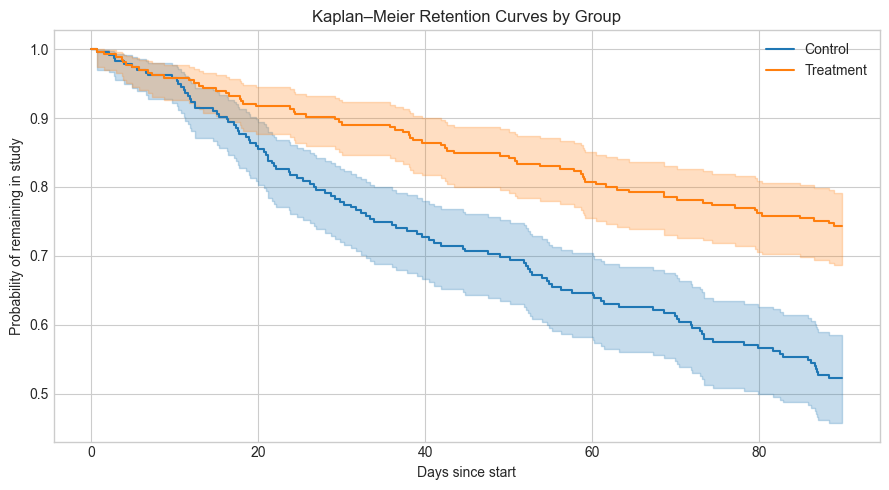


=== Cox Proportional Hazards Model ===
                         coef  exp(coef)             p
covariate                                             
treatment           -0.030843   0.969628  8.727914e-01
baseline_motivation -2.503801   0.081774  2.787658e-17
device_benefit      -0.001244   0.998756  9.493152e-10

Interpretation:
- Treatment hazard ratio (HR): 0.970 => lower dropout hazard (conditional on covariates)


In [13]:
# Survival analysis is a good tool for handling dropout (censoring).
# This section uses 'lifelines' (added to requirements.txt for reproducibility).
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
except ImportError as e:
    raise ImportError(
        "This section requires 'lifelines'. Install it (e.g., pip install lifelines) "
        "or add it to requirements.txt."
    ) from e

def analyze_dropout_patterns(n_participants=500, study_duration_days=90, rng=None):
    """Simulate and analyze participant dropout patterns using survival analysis.

    Data-generating story (toy):
    - Treatment increases device benefit on average.
    - Higher motivation and higher benefit reduce dropout hazard.

    Returns: (df, fitted CoxPH model)
    """
    rng = RNG if rng is None else rng

    # Treatment assignment
    treatment = rng.integers(0, 2, size=n_participants)

    # Baseline characteristics affecting dropout
    baseline_motivation = rng.uniform(0, 1, size=n_participants)

    # Device benefit (e.g., subjective satisfaction / perceived benefit)
    # IMPORTANT: depends on treatment per participant (not treatment.any()).
    device_benefit = rng.normal(loc=200 + 600 * treatment, scale=400, size=n_participants)

    # Dropout hazard: higher motivation + higher benefit -> lower hazard
    base_hazard = 0.02  # tuned so we see meaningful (but not overwhelming) dropout
    log_hazard = np.log(base_hazard) - 2.0 * baseline_motivation - 0.0010 * device_benefit
    dropout_hazard = np.exp(log_hazard).clip(1e-4, 1.0)

    # Time-to-dropout (days)
    dropout_times = rng.exponential(scale=1.0 / dropout_hazard)

    # Censor at study end
    observed_time = np.minimum(dropout_times, study_duration_days)
    event_occurred = (dropout_times < study_duration_days).astype(int)

    df = pd.DataFrame({
        'time': observed_time,
        'event': event_occurred,
        'treatment': treatment,
        'baseline_motivation': baseline_motivation,
        'device_benefit': device_benefit,
    })

    # Quick diagnostics (avoid deprecated groupby.apply behavior)
    retention = df.groupby('treatment')['event'].mean().rsub(1)
    print("=== Dropout Diagnostics ===")
    print(f"Overall dropout rate: {df['event'].mean():.1%}")
    print(f"Retention by group (1 - dropout rate):\n{retention.to_string()}")

    # Kaplan–Meier curves by treatment
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(9, 5))
    for group, label in [(0, 'Control'), (1, 'Treatment')]:
        g = df[df['treatment'] == group]
        kmf.fit(g['time'], g['event'], label=label)
        kmf.plot_survival_function(ci_show=True)
    plt.title('Kaplan–Meier Retention Curves by Group')
    plt.xlabel('Days since start')
    plt.ylabel('Probability of remaining in study')
    plt.tight_layout()
    plt.show()

    # Cox proportional hazards model
    # Include benefit + motivation to avoid attributing everything to treatment alone.
    cph = CoxPHFitter()
    cph.fit(
        df[['time', 'event', 'treatment', 'baseline_motivation', 'device_benefit']],
        duration_col='time',
        event_col='event',
    )
    print("\n=== Cox Proportional Hazards Model ===")
    display_cols = ['coef', 'exp(coef)', 'p']
    print(cph.summary[display_cols])

    # Interpret treatment HR
    hr_treat = float(cph.summary.loc['treatment', 'exp(coef)'])
    direction = "lower" if hr_treat < 1 else "higher"
    print("\nInterpretation:")
    print(f"- Treatment hazard ratio (HR): {hr_treat:.3f} => {direction} dropout hazard (conditional on covariates)")

    return df, cph

# Run analysis
dropout_data, cox_model = analyze_dropout_patterns()

## Strategy 4: Diverse Participant Pools

In [12]:
def generate_stratified_sample(population_size=10000, sample_size=500, rng=None):
    """Generate a stratified random sample with a fixed total sample size.

    This avoids (1) drift in total n and (2) pandas groupby.apply warnings.
    """
    rng = RNG if rng is None else rng

    # Define population strata
    strata = {
        'age': ['18-30', '31-45', '46-60', '61+'],
        'gender': ['M', 'F', 'NB'],
        'activity_level': ['sedentary', 'low', 'moderate', 'high'],
    }

    # Population distribution (toy but plausible proportions)
    pop_df = pd.DataFrame({
        'age': rng.choice(strata['age'], population_size, p=[0.25, 0.35, 0.25, 0.15]),
        'gender': rng.choice(strata['gender'], population_size, p=[0.48, 0.48, 0.04]),
        'activity_level': rng.choice(strata['activity_level'], population_size, p=[0.25, 0.35, 0.30, 0.10]),
    })

    # Allocate sample counts per stratum proportional to population counts
    stratum_cols = ['age', 'activity_level']
    stratum_sizes = pop_df.groupby(stratum_cols).size()
    probs = stratum_sizes / stratum_sizes.sum()
    expected = probs * sample_size
    base_counts = np.floor(expected).astype(int)
    remainder = int(sample_size - base_counts.sum())

    if remainder > 0:
        frac = (expected - base_counts).sort_values(ascending=False)
        for idx in frac.index[:remainder]:
            base_counts.loc[idx] += 1

    # Draw the sample
    pieces = []
    for (age, activity), n in base_counts.items():
        if n <= 0:
            continue
        group = pop_df[(pop_df['age'] == age) & (pop_df['activity_level'] == activity)]
        # pandas expects an int seed; derive one per stratum from RNG
        rs = int(rng.integers(0, 2**32 - 1))
        pieces.append(group.sample(n=n, replace=False, random_state=rs))

    sample_df = pd.concat(pieces, ignore_index=True)
    assert len(sample_df) == sample_size, f"Expected {sample_size}, got {len(sample_df)}"

    print(f"Population size: {population_size:,} | Sample size: {sample_size:,}")
    print("\nPopulation age distribution:")
    print(pd.crosstab(pop_df['age'], columns='count', normalize='columns').round(4))
    print("\nSample age distribution:")
    print(pd.crosstab(sample_df['age'], columns='count', normalize='columns').round(4))

    return sample_df

stratified_sample = generate_stratified_sample()

Population size: 10,000 | Sample size: 500

Population age distribution:
col_0   count
age          
18-30  0.2521
31-45  0.3488
46-60  0.2553
61+    0.1438

Sample age distribution:
col_0  count
age         
18-30  0.252
31-45  0.350
46-60  0.254
61+    0.144
